# Notebook 2, curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones, 2024
Alumnos: Nicolás Aquistapace y Pablo Barttfeld

En este lab 2 usaremos un entorno de grillas con una barrera de obstáculos que el agente tiene que atravesar. Para esto, habrá una única casilla "puente" por la que el agente podrá pasar. El modelo utilizado para entrenar al agente es **PPO (Proximal Policy Optimization)**. 

In [16]:
import pygame
import gymnasium as gym
from gymnasium import spaces
from typing import Tuple
import numpy as np
from stable_baselines3 import PPO
import torch as th
import matplotlib.pyplot as plt


Los parámetros elegidos, después de probar varias combinaciones, son:

**`"MlpPolicy"`**: Utiliza una política basada en perceptrones multicapa (MLP) con su configuración por defecto, que incluye 2 capas ocultas de 64 neuronas y función de activación ReLU.


**`device="cuda"`:**
   - Si está disponible, usamos GPU. No notamos que los tiempos sean menores que al usar CPU, seguro hay otros parámetros a modificar para que el GPU valga la pena.


**`n_steps=2048`:**
   - Número de pasos de interacción que el agente recolecta antes de actualizar la política. Probamos con números menores pero funcionaban peor, quizás porque la recompensa casi única está al final y más pasos permiten un horizonte más lejano.

**`learning_rate=1e-4`:**
   - Tasa de aprendizaje más lenta para mejorar la estabilidad del entrenamiento.

**`gamma=0.90`:**
   - Factor de descuento que controla cuánto valora el modelo las recompensas futuras en comparación con las inmediatas. Probamos valores más bajos y notamos que el agente no aprende a llegar a la recompensa. Por ejemplo se queda estancado cerca del puente.

**`ent_coef=0.01`:**
   - Coeficiente de entropía que fomenta la exploración al agregar una penalización a políticas demasiado deterministas.

**`model.learn(total_timesteps=100000)`:**
   - Entrena al modelo durante 100,000 pasos de interacción con el entorno.


   A continuación definimos el entorno



Las recompensas intentarán que el agente aprenda a atravesar el puente y seguir hasta la casilla final, la de arriba a la izquierda. Se penaliza al agente por cada paso tomado de manera progresiva por la distancia al objetivo. Las casillas obstáculo dan una penalización de -5, chica comparada con la recompensa final de 50. También incluimos una recompensa en la casilla puente, de 25, porque no alcanza aparentemente con los pequeños castigos de las casillas obstáculo.

In [17]:
class GoToTopLeftEnv(gym.Env):
    metadata = {"render.modes": ["console", "human"]}
    LEFT = 0
    RIGHT = 1
    UP = 2
    DOWN = 3

    def __init__(self, grid_size=10, obstacle_row=5):
        super(GoToTopLeftEnv, self).__init__()
        self.grid_size = grid_size
        self.obstacle_row = obstacle_row
        self.agent_pos = [grid_size - 1, grid_size - 1]  # Inicializa al agente en la esquina inferior derecha
        n_actions = 4
        self.action_space = spaces.Discrete(n_actions)
        self.observation_space = spaces.Box(
            low=0, high=self.grid_size - 1, shape=(2,), dtype=np.int32
        )

    def reset(self, seed=None) -> Tuple[np.array, dict]:
        self.agent_pos = [self.grid_size - 1, self.grid_size - 1]  # Reposiciona al agente en la esquina inicial
        return np.array(self.agent_pos), {}

    def step(self, action):
        if action == self.LEFT:
            self.agent_pos[1] = max(self.agent_pos[1] - 1, 0)
        elif action == self.RIGHT:
            self.agent_pos[1] = min(self.agent_pos[1] + 1, self.grid_size - 1)
        elif action == self.UP:
            self.agent_pos[0] = max(self.agent_pos[0] - 1, 0)
        elif action == self.DOWN:
            self.agent_pos[0] = min(self.agent_pos[0] + 1, self.grid_size - 1)

        # Verificar si el agente está en una celda de obstáculo
        if self.agent_pos[0] == self.obstacle_row and self.agent_pos[1] != 3:
            reward = -5  # Penalización alta por caer en el obstáculo
            terminated = False  # El episodio no termina en entrenamiento
        elif self.agent_pos[0] == self.obstacle_row and self.agent_pos[1] == 3:
            reward = 25  
            terminated = False  # El episodio no termina en entrenamiento
        else:
            # Condición de éxito: el agente llega a la posición superior izquierda (0,0)
            terminated = self.agent_pos == [0, 0]
            distance_to_goal = np.linalg.norm(np.array([0, 0]) - np.array(self.agent_pos))  # Distancia a la meta
            reward = .2 - distance_to_goal * 0.05  # Penalización progresiva por distancia
            if terminated:
                reward += 50  # Recompensa alta en la meta

        return np.array(self.agent_pos), reward, terminated, False, {}

# Entrenamiento del agente con el modelo PPO
env = GoToTopLeftEnv(grid_size=10, obstacle_row=5)
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    device="cuda",
    n_steps=2048,  
    learning_rate=1e-4,  
    gamma=0.9, 
    ent_coef=0.01, 
)
model.learn(total_timesteps=100000)



Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 384      |
|    ep_rew_mean     | -37.9    |
| time/              |          |
|    fps             | 1784     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 192         |
|    ep_rew_mean          | 5.52        |
| time/                   |             |
|    fps                  | 1274        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014100049 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss   

Con el modelo ya entrenado vemos como se mueve el agente. Para ver el entorno y la conducta del agente usamos la librería de juegos <a href="https://www.pygame.org/docs/" target="_blank">Pygame</a>

En cada casilla se dibuja una flecha, que representa la acción óptima según la política aprendida del agente. Estas flechas muestran hacia dónde se movería el agente. Como usamos un PPO determinista (deterministic=True) el agente va a moverse, en cada casilla, en la dirección de la flecha. 


Dejamos un video <a href="https://www.df.uba.ar/~pablob/datos/video1.mp4" target="_blank">acá</a> para ver el entorno gráfico sin ejecutar el notebook.


In [30]:
# Configuración de Pygame para visualizar después del entrenamiento
pygame.init()
screen = pygame.display.set_mode((500, 500))
pygame.display.set_caption("Go To Top Left - Agente Entrenado con Obstáculos")
WHITE = (255, 255, 255)
BLUE = (0, 0, 255)
GREEN = (0, 255, 0)
GRAY = (200, 200, 200)
BLACK = (0, 0, 0)
RED = (255, 0, 0)  # Color para las casillas de obstáculos
BLOCK_SIZE = 50  # Tamaño de cada bloque en la grilla
FONT = pygame.font.SysFont(None, 18)  # Fuente para mostrar los valores Q

# Función para dibujar el entorno en Pygame con valores Q y flechas
def draw_env_with_q_and_policy(state, grid_size=10, obstacle_row=5, model=None):

    
    screen.fill(WHITE)
    for row in range(grid_size):
        for col in range(grid_size):
            # Marca las celdas de la fila de obstáculos en rojo en posiciones pares
            if row == obstacle_row and col != 3:
                color = RED
            elif (row, col) == (0, 0):
                color = GREEN  # Meta
            elif (row, col) == (state[0], state[1]):
                color = BLUE  # Agente
            else:
                color = GRAY  # Celdas normales
            
            pygame.draw.rect(screen, color, (col * BLOCK_SIZE, row * BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE))
            # Predecir el valor Q para cada celda y dibujar en el centro
            if model:
                state_tensor = th.tensor([[row, col]], dtype=th.float32, device=model.device)
                q_value = model.policy.predict_values(state_tensor).item()
                #text = FONT.render(f"{q_value:.1f}", True, BLACK)
                #text_rect = text.get_rect(center=(col * BLOCK_SIZE + BLOCK_SIZE // 2, row * BLOCK_SIZE + BLOCK_SIZE // 2))
                #screen.blit(text, text_rect)

                # Obtener la acción óptima para la celda actual y dibujar una flecha
                action, _ = model.predict(np.array([row, col]), deterministic=True)
                arrow_start = (col * BLOCK_SIZE + BLOCK_SIZE // 2, row * BLOCK_SIZE + BLOCK_SIZE // 2)
                arrow_end = arrow_start
                if action == env.UP:
                    arrow_end = (arrow_start[0], arrow_start[1] - BLOCK_SIZE // 3)
                elif action == env.DOWN:
                    arrow_end = (arrow_start[0], arrow_start[1] + BLOCK_SIZE // 3)
                elif action == env.LEFT:
                    arrow_end = (arrow_start[0] - BLOCK_SIZE // 3, arrow_start[1])
                elif action == env.RIGHT:
                    arrow_end = (arrow_start[0] + BLOCK_SIZE // 3, arrow_start[1])
                pygame.draw.line(screen, BLACK, arrow_start, arrow_end, 2)
                pygame.draw.circle(screen, BLACK, arrow_end, 3)

    # Dibujar las líneas de la cuadrícula
    for x in range(0, grid_size * BLOCK_SIZE, BLOCK_SIZE):
        pygame.draw.line(screen, BLACK, (x, 0), (x, grid_size * BLOCK_SIZE))
    for y in range(0, grid_size * BLOCK_SIZE, BLOCK_SIZE):
        pygame.draw.line(screen, BLACK, (0, y), (grid_size * BLOCK_SIZE, y))

    pygame.display.flip()

# Visualización en Pygame del agente entrenado
obs, _ = env.reset()
done = False
pygame.time.wait(1000)

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    
    draw_env_with_q_and_policy(obs, grid_size=10, obstacle_row=5, model=model)
    pygame.time.delay(500)

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            done = True
            pygame.quit()
            break

    if done and reward > 0:
        pygame.time.delay(300)
        break

pygame.quit()


A continuación exploramos los valores de Q que se estimaron para cada celda. 

Valores Q aproximados en formato de cuadrícula:
 40.60  40.61  40.53  39.46  36.71  35.80  35.49  35.08  34.50  33.73
 40.61  40.56  39.45  36.54  35.90  35.77  35.57  35.23  34.70  33.98
 40.58  39.71  36.55  35.92  35.86  35.79  35.61  35.26  34.71  33.95
 40.15  37.03  35.95  35.89  35.86  35.79  35.59  35.17  34.46  33.46
 38.16  36.06  35.90  35.89  35.86  35.77  35.51  34.88  33.72  31.98
 36.44  35.92  35.89  35.88  35.84  35.69  35.21  33.94  31.55  28.42
 36.00  35.90  35.89  35.86  35.76  35.32  33.91  30.96  27.12  23.50
 35.91  35.89  35.87  35.77  35.30  33.61  30.14  26.18  22.79  19.92
 35.89  35.86  35.74  35.19  33.24  29.58  25.82  22.73  20.10  17.73
 35.82  35.65  34.96  32.83  29.34  26.00  23.20  20.65  18.22  16.00


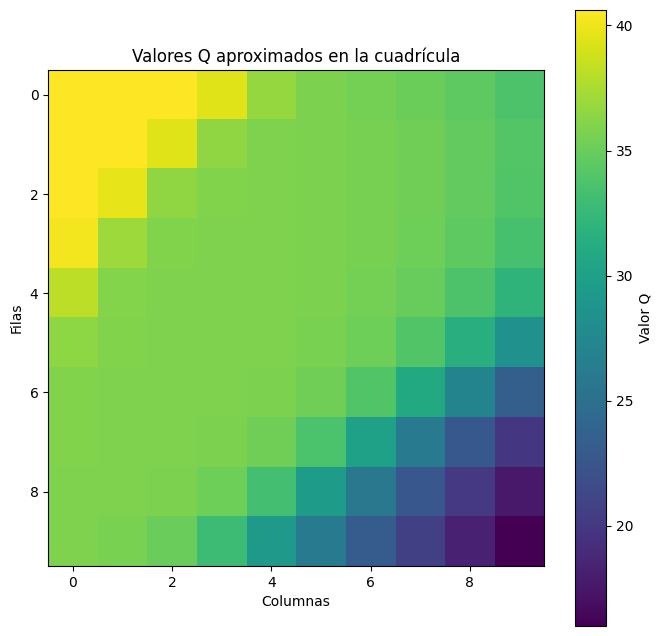

In [19]:
import matplotlib.pyplot as plt

def print_q_grid(grid_size, model):
    print("Valores Q aproximados en formato de cuadrícula:")
    q_grid = np.zeros((grid_size, grid_size))  # Crear una cuadrícula vacía para almacenar los valores Q
    for row in range(grid_size):
        for col in range(grid_size):
            # Crear el estado actual como tensor de PyTorch
            state_tensor = th.tensor([[row, col]], dtype=th.float32, device=model.device)
            # Predecir el valor Q para la celda actual
            q_value = model.policy.predict_values(state_tensor).item()
            q_grid[row, col] = q_value  # Almacenar en la cuadrícula

    # Imprimir la cuadrícula en formato texto
    for row in range(grid_size):
        print(" ".join(f"{q_grid[row, col]:6.2f}" for col in range(grid_size)))

    # Plotear la cuadrícula como una imagen de calor
    plt.figure(figsize=(8, 8))
    plt.imshow(q_grid, cmap='viridis', interpolation='nearest')  # Usar colormap 'viridis'
    plt.colorbar(label="Valor Q")  # Añadir una barra de color para indicar los valores Q
    plt.title("Valores Q aproximados en la cuadrícula")
    plt.xlabel("Columnas")
    plt.ylabel("Filas")
    plt.show()

# Llamar a la función
print_q_grid(10, model)


Los valores Q muestran un patrón monótono creciente hacia la meta, lo que refleja una política bien aprendida para guiar al agente de manera eficiente hacia el objetivo. Sin embargo, los valores no resaltan la importancia del puente en la fila de obstáculos (a pesar de que el elige esa casilla para pasar). Esto sugiere que la política aprendida considera el puente simplemente como parte de la trayectoria óptima y no como un punto crítico que afecte significativamente las recompensas acumuladas en comparación con las demás celdas. Probablemente la recompensa del puente sera importante en los primeros momentos del aprendizaje.

A continuación exploramos la incertidumbre del modelo en la estimación de los Q, inspirados en trabajos que en humanos estudian la incerteza en estimaciones de valor, como  <a href="https://academic.oup.com/nc/article/2019/1/niz004/5486647" target="_blank">este trabajo</a> en que muestran que la confianza en las estimaciones de valor modula las estrategias de exploración o explotación.

Si bien la analogía en nuestro caso es un poco forzada y solamente inspirada en el trabajo mencionado, buscamos obtener una medida de incerteza en las decisiones del agente calculando la entropía de la política entrenada para cada celda. Para cada estado o casillero se evalúa la política del modelo, obteniendo las probabilidades de las acciones posibles. Luego, se calcula la entropía de estas probabilidades como una medida de incertidumbre: valores altos indican que el modelo no tiene una acción clara preferida (alta incertidumbre), mientras que valores bajos reflejan confianza en la acción óptima. 


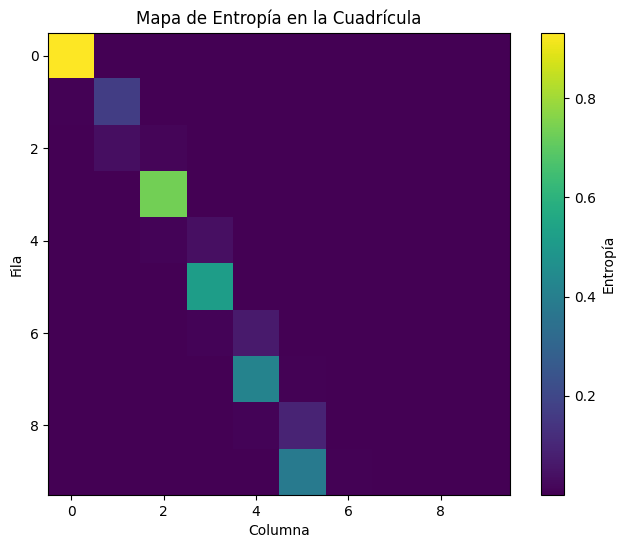

In [20]:
# Función para calcular la entropía de la política para cada celda
def compute_entropy_grid(grid_size, model):
    entropy_grid = np.zeros((grid_size, grid_size))
    for row in range(grid_size):
        for col in range(grid_size):
            state_tensor = th.tensor([[row, col]], dtype=th.float32, device=model.device)
            with th.no_grad():
                latent = model.policy.extract_features(state_tensor)
                latent_pi = model.policy.mlp_extractor.forward_actor(latent)
                action_logits = model.policy.action_net(latent_pi)
                action_probs = th.softmax(action_logits, dim=-1)
                entropy = -th.sum(action_probs * th.log(action_probs + 1e-8)).item()
                entropy_grid[row, col] = entropy
    return entropy_grid

entropy_grid = compute_entropy_grid(10, model)

plt.figure(figsize=(8, 6))
plt.imshow(entropy_grid, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Entropía')
plt.title('Mapa de Entropía en la Cuadrícula')
plt.xlabel('Columna')
plt.ylabel('Fila')
plt.show()



Vemos que hay una diagonal de alta entropía hacia la meta, lo que indica que el modelo tiene mayor incertidumbre al decidir las acciones en esta región crítica. Esto sugiere que, aunque el puente es la única ruta viable para evitar penalizaciones, el agente enfrenta dudas significativas sobre cómo proceder. 
También exploramos la cantidad de veces que el agente entrenado visita cada casilla:

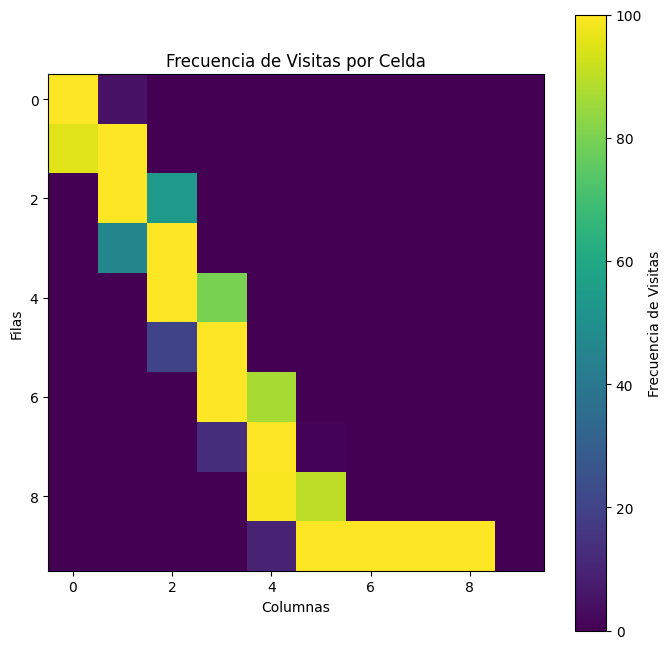

In [21]:
def debug_visit_counts(env, model, episodes=100, steps_per_episode=50):
    visit_count = np.zeros((env.grid_size, env.grid_size))

    for _ in range(episodes):
        env.reset()
        for _ in range(steps_per_episode):
            state_tensor = th.tensor([env.agent_pos], dtype=th.float32, device=model.device)
            with th.no_grad():
                action, _ = model.policy.predict(state_tensor)
            obs, _, terminated, _, _ = env.step(action)
            visit_count[env.agent_pos[0], env.agent_pos[1]] += 1
            if terminated:
                break

    plt.figure(figsize=(8, 8))
    plt.imshow(visit_count, cmap='viridis', interpolation='nearest')
    plt.colorbar(label="Frecuencia de Visitas")
    plt.title("Frecuencia de Visitas por Celda")
    plt.xlabel("Columnas")
    plt.ylabel("Filas")
    plt.show()

# Llamar a la función
debug_visit_counts(env, model)


Vemos que el agente tiene un camino preferido, y se desvía muy poco en cada ejecución: si bien no es necesario comenzar el recorrido horizontalmente hacia la izquierda, es lo que el agente hace, quizás evitando lo más posible la barrera de refuerzo negativo en la fila central. Luego se dirige al puente y al destino de manera muy poco exploratoria y sigue en diagonal a la meta.